# Plotting fire locations and MaxEnt fire probabilities

Authors: Jatan Buch (v1, 230328) || (v2, 240122)

## Load libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import h5py
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader
import scipy.io as sio 

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

#Plot modules
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.legend_handler import HandlerTuple
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
#import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import shap

#modules for Neural Network
# import tensorflow as tf
# import tensorflow_probability as tfp
# tfd= tfp.distributions
# from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
# from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

## Functions

In [2]:
def init_masked_pred_prob_df_func(alpha= 1, min_path=0.01, quad_features= 0, sav_flag= False):

    """
    Initializing the dataframe for storing the masked predicted probabilities corresponding to each threshold group

    alpha: elastic net regularization parameter
    min_path: minimum path length for the threshold groups
    quad_features: whether to include quadratic features in the model
    """

    if sav_flag:
        p_sol_mat= sio.loadmat('../gpl_analysis/data/generated_data/p_sol_alpha=%s,'%str(alpha) + 'min_path=%.2f,'%min_path + 'quad_features=%d.mat'%quad_features)
        threshold_vals= sio.loadmat('../gpl_analysis/data/generated_data/threshold_vals_alpha=%s,'%str(alpha) + 'min_path=%.2f,'%min_path + 'quad_features=%d.mat'%quad_features)
        threshold_vals= threshold_vals['ind_threshold_groups'].flatten().astype(int)

        for tval in tqdm(threshold_vals):
            prior_df= pd.read_hdf('../sav_files/pred_fire_masked_prob_all_mons.h5')
            prob_freq_df= prior_df.loc[:, 0:1].copy(deep= True)
            prob_freq_df.columns= ['findx', 'prior_prob']
            prob_freq_df.drop(columns= ['findx'], inplace= True)
            for mindx in range(0, 12):
                prob_freq_df['pred_fire_prob_%d'%mindx]= np.zeros_like(prob_freq_df['prior_prob'], dtype= np.float32)
                prob_freq_df.loc[~prob_freq_df['prior_prob'].isna(), 'pred_fire_prob_%d'%mindx]= np.reshape(p_sol_mat['sol_p'][:, tval], (23903, 12))[:, mindx]
                prob_freq_df.loc[prob_freq_df['prior_prob'].isna(), 'pred_fire_prob_%d'%mindx]= np.nan

            prob_freq_df= prob_freq_df.drop(columns= ['prior_prob'])
            prob_freq_df.columns= range(prob_freq_df.columns.size)
            prob_freq_df.to_hdf('../sav_files/pred_fire_prob_dfs/pred_fire_prob_alpha=%s,'%str(alpha) + 'min_path=%.2f,'%min_path + 'quad_features=%d,'%quad_features + \
                                                                                                                                            'tval=%d.h5'%tval, key='df', mode='w')
    else:
        threshold_vals= sio.loadmat('../gpl_analysis/data/generated_data/threshold_vals_alpha=%s,'%str(alpha) + 'min_path=%.2f,'%min_path + 'quad_features=%d.mat'%quad_features)
        threshold_vals= threshold_vals['ind_threshold_groups'].flatten().astype(int)
        lambda_vals= sio.loadmat('../gpl_analysis/data/generated_data/reg_path_alpha=%s,'%str(alpha) + 'min_path=%.2f,'%min_path + 'quad_features=%d.mat'%quad_features)['lambda'][0]

        return threshold_vals, lambda_vals

In [3]:
def init_pred_prob_xarr(alpha= 1, min_path= 0.01, quad_features= 0, tval_arr= None, tindx= None):

    pred_prob_df= pd.read_hdf('../sav_files/pred_fire_prob_dfs/pred_fire_prob_alpha=%s,'%str(alpha) + 'min_path=%.2f,'%min_path + 'quad_features=%d,'%quad_features + 'tval=%d.h5'%tval_arr[tindx])
    pred_freq_xarr= xarray.DataArray(data= pred_prob_df[0].to_numpy().reshape(208, 155),
                    dims=["Y", "X"],
                    coords=dict(
                        X=(["X"], np.linspace(-2349250, -501250, 155)),
                        Y=(["Y"], np.linspace(3166500, 682500, 208)),),) #maxent_prob_df[0]

    for i in tqdm(range(11)):
        tmp_freq_xarr= xarray.DataArray(data= pred_prob_df[i+1].to_numpy().reshape(208, 155),
                    dims=["Y", "X"],
                    coords=dict(
                        X=(["X"], np.linspace(-2349250, -501250, 155)),
                        Y=(["Y"], np.linspace(3166500, 682500, 208)),),)
        pred_freq_xarr= xarray.concat([pred_freq_xarr, tmp_freq_xarr], dim= 'month')

    return pred_freq_xarr

In [4]:
def bailey_ecoprovince_shp(region, lflag = 'L3', sbflag= True, coord= False):
    
    #reading in the shape file publcily available on the EPA website here: https://www.epa.gov/eco-research/level-iii-and-iv-ecoregions-continental-united-states
    #sbflag = False for plotting without state boundaries
    if lflag == 'L3':
        if not sbflag:
            ecoregionshp= gpd.read_file("../data/us_eco_l3/us_eco_l3.shp", crs="epsg:5070")
        else:
            ecoregionshp= gpd.read_file("../data/us_eco_l3_state_boundaries/us_eco_l3_state_boundaries.shp", crs="epsg:5070")
    elif lflag == 'L4':
        ecoregionshp= gpd.read_file("../data/us_eco_l4_state_boundaries/us_eco_l4.shp", crs="epsg:5070")
    
    if not sbflag:
        if region == "ca_south_coast":
            regshp= ecoregionshp[((ecoregionshp['US_L3CODE'] == '8')|(ecoregionshp['US_L3CODE'] == '85'))]
        elif region == "ca_cent_coast":
            regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '6')]
        elif region == "ca_sierra":
            regshp= ecoregionshp[((ecoregionshp['US_L3CODE'] == '4')|(ecoregionshp['US_L3CODE'] == '5')|(ecoregionshp['US_L3CODE'] == '9'))]
        elif region == "ca_north_coast":
            regshp= ecoregionshp[((ecoregionshp['US_L3CODE'] == '1')|(ecoregionshp['US_L3CODE'] == '78'))];
        elif region == "pnw_mts":
            regshp= ecoregionshp[((ecoregionshp['US_L3CODE'] == '1')| \
                (ecoregionshp['US_L3CODE'] == '4')|(ecoregionshp['US_L3CODE'] == '9')|(ecoregionshp['US_L3CODE'] == '77')|(ecoregionshp['US_L3CODE'] == '78'))]
        elif region == "northern_great_plains":
            regshp= ecoregionshp[((ecoregionshp['US_L3CODE'] == '42')|(ecoregionshp['US_L3CODE'] == '43'))]
    else: 
        if region == "ca_south_coast":
            regshp= ecoregionshp[(ecoregionshp['STATE_NAME'] == 'California')&
                     ((ecoregionshp['US_L3CODE'] == '8')|(ecoregionshp['US_L3CODE'] == '85'))]
        elif region == "ca_cent_coast":
            regshp= ecoregionshp[(ecoregionshp['STATE_NAME'] == 'California')&(ecoregionshp['US_L3CODE'] == '6')]
        elif region == "ca_sierra":
            regshp= ecoregionshp[(ecoregionshp['STATE_NAME'] == 'California')&
                     ((ecoregionshp['US_L3CODE'] == '4')|(ecoregionshp['US_L3CODE'] == '5')|(ecoregionshp['US_L3CODE'] == '9'))]
        elif region == "ca_north_coast":
            regshp= ecoregionshp[(ecoregionshp['STATE_NAME'] == 'California')&
                     ((ecoregionshp['US_L3CODE'] == '1')|(ecoregionshp['US_L3CODE'] == '78'))]
        elif region == "ca_total":
            regshp= ecoregionshp[(ecoregionshp['STATE_NAME'] == 'California')&
                     ((ecoregionshp['US_L3CODE'] == '1')|(ecoregionshp['US_L3CODE'] == '4')|(ecoregionshp['US_L3CODE'] == '5')\
                      |(ecoregionshp['US_L3CODE'] == '6')|(ecoregionshp['US_L3CODE'] == '8')|(ecoregionshp['US_L3CODE'] == '9')\
                      |(ecoregionshp['US_L3CODE'] == '78')|(ecoregionshp['US_L3CODE'] == '85'))];
        elif region == "pnw_mts":
            regshp= ecoregionshp[((ecoregionshp['STATE_NAME'] == 'Washington')|(ecoregionshp['STATE_NAME'] == 'Oregon'))&((ecoregionshp['US_L3CODE'] == '1')| \
                (ecoregionshp['US_L3CODE'] == '4')|(ecoregionshp['US_L3CODE'] == '9')|(ecoregionshp['US_L3CODE'] == '77')|(ecoregionshp['US_L3CODE'] == '78'))]
        elif region == "northern_great_plains":
            regshp= ecoregionshp[((ecoregionshp['STATE_NAME'] == 'Montana')|(ecoregionshp['STATE_NAME'] == 'Wyoming'))&\
                             ((ecoregionshp['US_L3CODE'] == '42')|(ecoregionshp['US_L3CODE'] == '43'))]
            
    if region == "columbia_plateau":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '10')]
    elif region == "northern_rockies":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '15')|(ecoregionshp['US_L3CODE'] == '41')]
    elif region == "middle_rockies":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '11')|(ecoregionshp['US_L3CODE'] == '16')|(ecoregionshp['US_L3CODE'] == '17')]
    elif region == "southern_rockies":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '19')|(ecoregionshp['US_L3CODE'] == '21')]
    elif region == "colorado_plateau":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '20')|(ecoregionshp['US_L3CODE'] == '22')]    
    elif region == "am_semidesert":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '14')|(ecoregionshp['US_L3CODE'] == '81')]
    elif region == "aznm_mts":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '23')|(ecoregionshp['US_L3CODE'] == '79')]
    elif region == "im_semidesert":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '12')|(ecoregionshp['US_L3CODE'] == '18')|(ecoregionshp['US_L3CODE'] == '80')]
    elif region == "im_desert":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '13')]
    elif region == "ch_desert":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '24')]
    elif region == "high_plains":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '25')]
    elif region == "sw_tablelands":
        regshp= ecoregionshp[(ecoregionshp['US_L3CODE'] == '26')]
    
    return regshp

In [5]:
def coord_transform(coord_a, coord_b, input_crs= 'WGS84', output_crs= 'EPSG:5070'):
    #function to convert coordinates between different reference systems with a little help from pyproj.Transformer
    #custom crs i/o with https://gis.stackexchange.com/questions/427786/pyproj-and-a-custom-crs
    
    transformer= Transformer.from_crs(input_crs, output_crs, always_xy= True)
        
    # we add another if-else loop to account for differences in input size: for different sizes, we first construct a meshgrid,
    # before transforming coordinates. Thus, the output types will differ depending on the input.
    if len(coord_a) == len(coord_b):
        return transformer.transform(coord_a, coord_b) 
    else:
        coord_grid_a, coord_grid_b= np.meshgrid(coord_a, coord_b)
        return transformer.transform(coord_grid_a, coord_grid_b)

## Data processing

In [6]:
wildfire_df= pd.read_csv("../data/firelist/west_US_fires_1984_2020.txt", 
                         usecols= (0, 1, 9, 18, 19, 20, 21, 22, 23, 24), delimiter= ',') #insert correct file path WUMI fire data file here
prior_df= pd.read_hdf('../sav_files/pred_fire_masked_prob_all_mons.h5')
prior_xarr= xarray.DataArray(data= prior_df[0].to_numpy().reshape(208, 155),
                    dims=["Y", "X"],
                    coords=dict(
                        X=(["X"], np.linspace(-2349250, -501250, 155)),
                        Y=(["Y"], np.linspace(3166500, 682500, 208)),),)
for i in tqdm(range(11)):
    tmp_prior_xarr= xarray.DataArray(data= prior_df[i+1].to_numpy().reshape(208, 155),
                    dims=["Y", "X"],
                    coords=dict(
                        X=(["X"], np.linspace(-2349250, -501250, 155)),
                        Y=(["Y"], np.linspace(3166500, 682500, 208)),),)
    prior_xarr= xarray.concat([prior_xarr, tmp_prior_xarr], dim= 'month')
lat_long_fire_grid= coord_transform(prior_xarr['X'][:].data, prior_xarr['Y'][:].data, input_crs= 'EPSG:5070', output_crs= 'EPSG:4326')

# h5= h5py.File('../sav_files/my_example_file2.h5','r')
# maxent_prob_df= pd.DataFrame(np.reshape(h5['data'], (12, 32240)).T) 
# longterm_prob_df= pd.read_hdf('../sav_files/clim_fire_mon_prob_dfs/pred_fire_masked_prob_all_mons.h5') #insert correct file path for MaxEnt fire probability here

#init_masked_pred_prob_df_func(alpha= alpha, min_path= min_path, quad_features= quad_features, sav_flag= True) #uncomment to generate the masked predicted probability dataframes

100%|██████████| 11/11 [00:00<00:00, 498.37it/s]


## Plotting

Makes extensive use of the `cartopy` plotting library

### Fig. 1

In [8]:
sierra_gdf= bailey_ecoprovince_shp(region= 'ca_sierra', sbflag= True)
sierra_gdf= sierra_gdf.to_crs(epsg= 4326)
scoast_gdf= bailey_ecoprovince_shp(region= 'ca_south_coast', sbflag= False)
scoast_gdf= scoast_gdf.to_crs(epsg= 4326)
ncoast_gdf= bailey_ecoprovince_shp(region= 'ca_north_coast', sbflag= True)
ncoast_gdf= ncoast_gdf.to_crs(epsg= 4326)
ccoast_gdf= bailey_ecoprovince_shp(region= 'ca_cent_coast', sbflag= False)
ccoast_gdf= ccoast_gdf.to_crs(epsg= 4326)

pnw_gdf= bailey_ecoprovince_shp(region= 'pnw_mts', sbflag= True)
pnw_gdf= pnw_gdf.to_crs(epsg= 4326)
columbia_plateau_gdf= bailey_ecoprovince_shp(region= 'columbia_plateau', sbflag= False)
columbia_plateau_gdf= columbia_plateau_gdf.to_crs(epsg= 4326)

nrockies_gdf= bailey_ecoprovince_shp(region= 'northern_rockies', sbflag= False)
nrockies_gdf= nrockies_gdf.to_crs(epsg= 4326)
mrockies_gdf= bailey_ecoprovince_shp(region= 'middle_rockies', sbflag= False)
mrockies_gdf= mrockies_gdf.to_crs(epsg= 4326)
srockies_gdf= bailey_ecoprovince_shp(region= 'southern_rockies', sbflag= False)
srockies_gdf= srockies_gdf.to_crs(epsg= 4326)

col_plat_gdf= bailey_ecoprovince_shp(region= 'colorado_plateau', sbflag= False)
col_plat_gdf= col_plat_gdf.to_crs(epsg= 4326)
am_semidesert_gdf= bailey_ecoprovince_shp(region= 'am_semidesert', sbflag= False)
am_semidesert_gdf= am_semidesert_gdf.to_crs(epsg= 4326)
aznm_mts_gdf=  bailey_ecoprovince_shp(region= 'aznm_mts', sbflag= False)
aznm_mts_gdf= aznm_mts_gdf.to_crs(epsg= 4326)

im_semidesert_gdf= bailey_ecoprovince_shp(region= 'im_semidesert', sbflag= False)
im_semidesert_gdf= im_semidesert_gdf.to_crs(epsg= 4326)
im_desert_gdf= bailey_ecoprovince_shp(region= 'im_desert', sbflag= False)
im_desert_gdf= im_desert_gdf.to_crs(epsg= 4326)
ch_desert_gdf= bailey_ecoprovince_shp(region= 'ch_desert', sbflag= False)
ch_desert_gdf= ch_desert_gdf.to_crs(epsg= 4326)

ngreat_plains_gdf= bailey_ecoprovince_shp(region= 'northern_great_plains', sbflag= True)
ngreat_plains_gdf= ngreat_plains_gdf.to_crs(epsg= 4326)
high_plains_gdf= bailey_ecoprovince_shp(region= 'high_plains', sbflag= False)
high_plains_gdf= high_plains_gdf.to_crs(epsg= 4326)
sw_table_gdf= bailey_ecoprovince_shp(region= 'sw_tablelands', sbflag= False)
sw_table_gdf= sw_table_gdf.to_crs(epsg= 4326)

forest_area_gdf= pd.concat([sierra_gdf, ncoast_gdf, ccoast_gdf, scoast_gdf, pnw_gdf, nrockies_gdf, mrockies_gdf, srockies_gdf, aznm_mts_gdf], axis= 0)
desert_area_gdf= pd.concat([columbia_plateau_gdf, col_plat_gdf, im_semidesert_gdf, im_desert_gdf, am_semidesert_gdf, ch_desert_gdf, sw_table_gdf], axis= 0)
plains_area_gdf= pd.concat([ngreat_plains_gdf, high_plains_gdf], axis= 0)

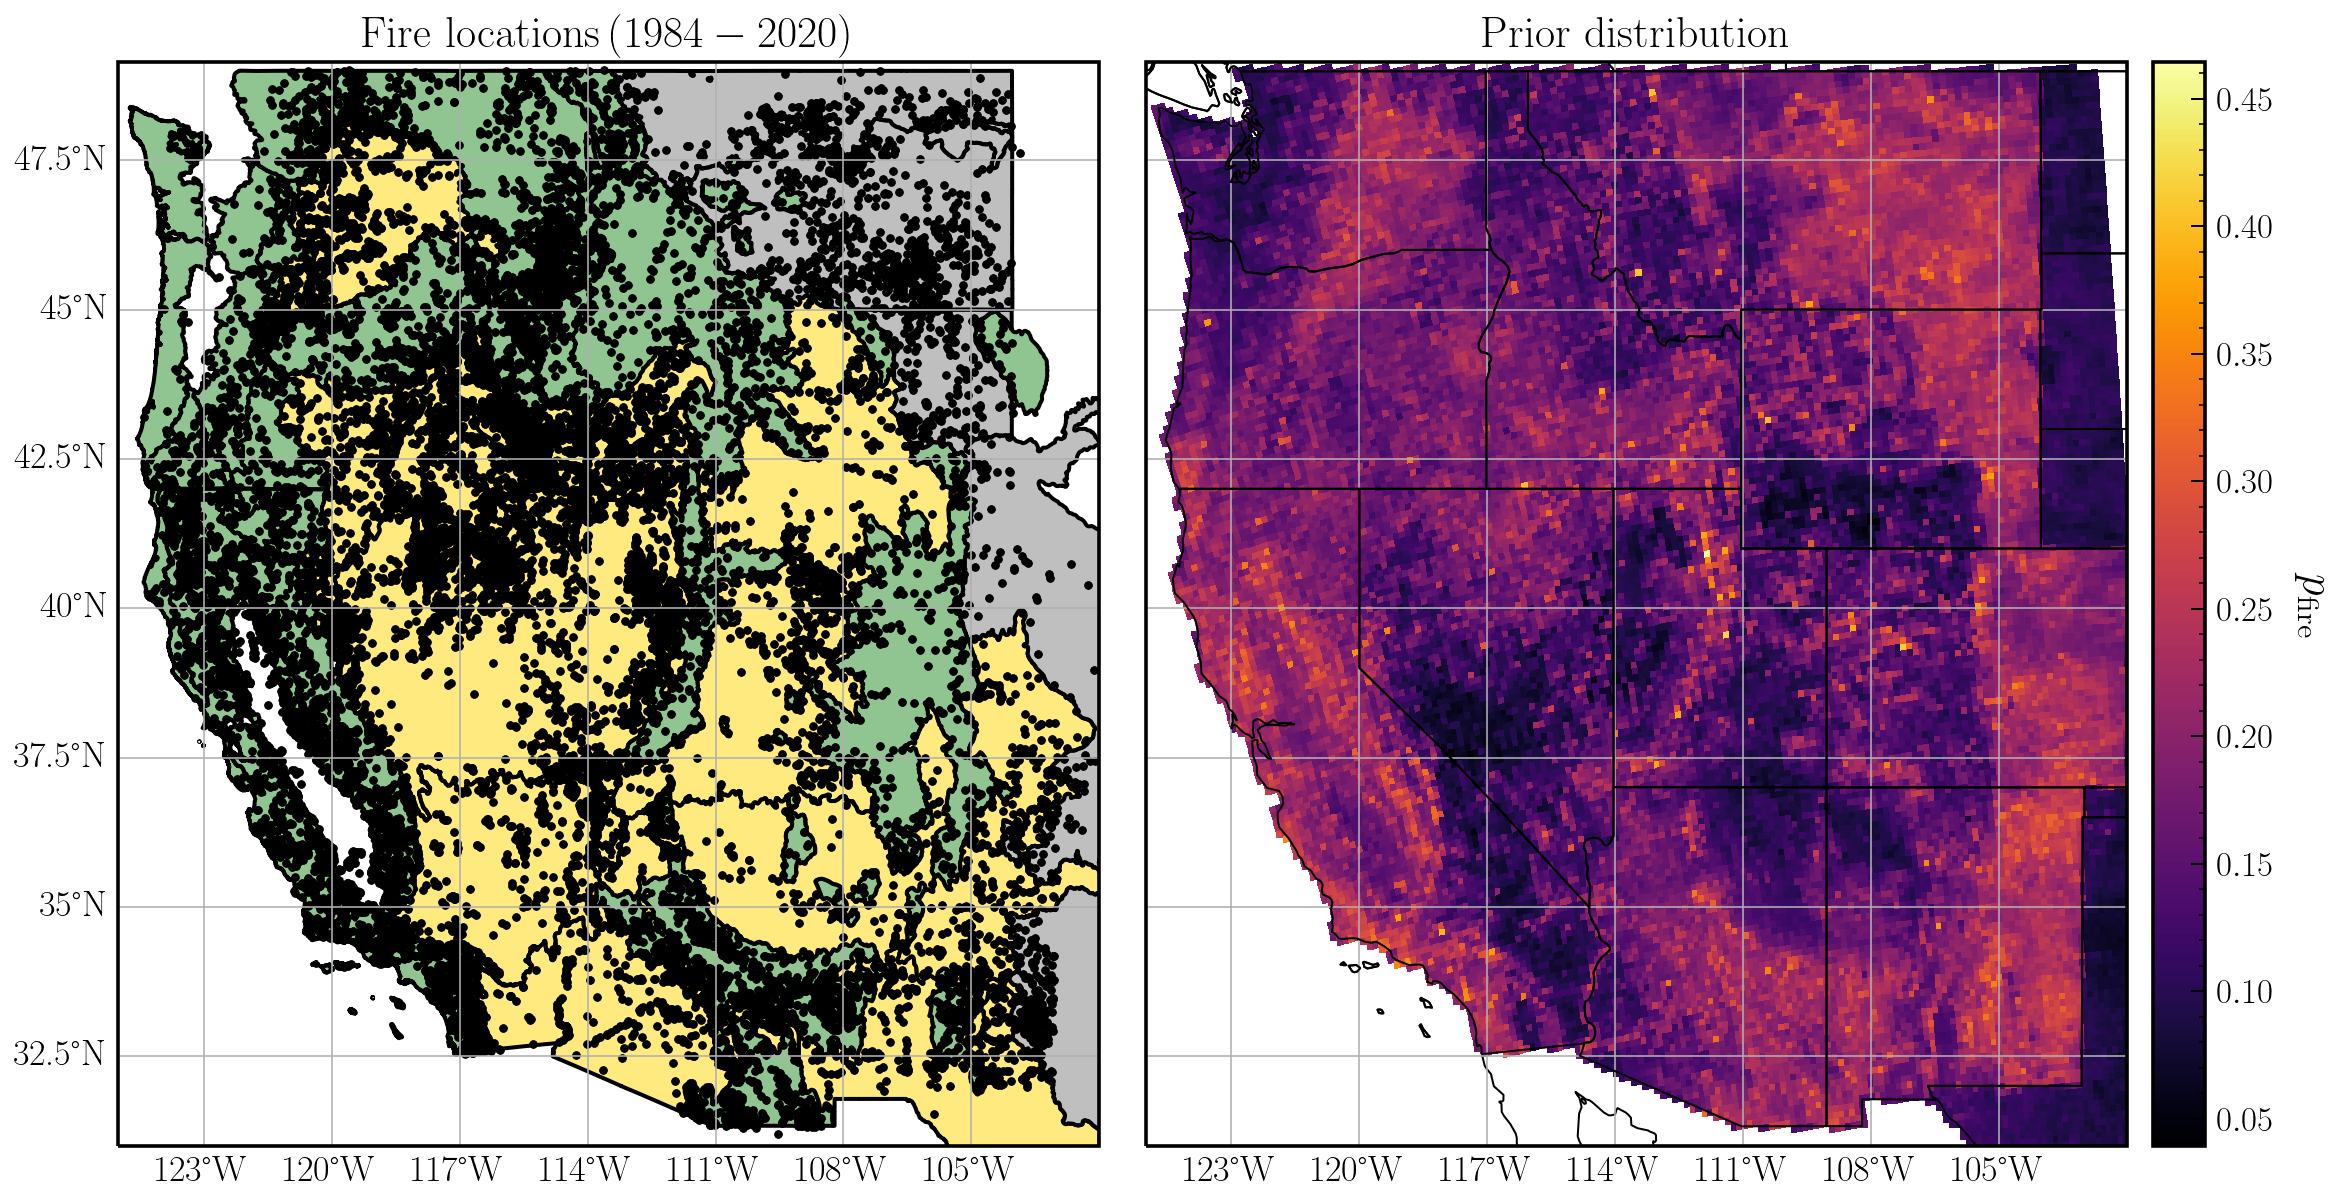

In [21]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4)

ax= fig.add_subplot(gs[0:3, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_geometries(forest_area_gdf.geometry, crs= ccrs.PlateCarree(), facecolor= colors.to_rgba('forestgreen', alpha= 0.5), \
                                                                          edgecolor= colors.to_rgba('black', alpha= 1.0), lw= 2, zorder= 1)
ax.add_geometries(desert_area_gdf.geometry, crs= ccrs.PlateCarree(), facecolor= colors.to_rgba('gold', alpha= 0.5), \
                                                                          edgecolor= colors.to_rgba('black', alpha= 1.0), lw= 2, zorder= 1)
ax.add_geometries(plains_area_gdf.geometry, crs= ccrs.PlateCarree(), facecolor= colors.to_rgba('gray', alpha= 0.5), \
                                                                          edgecolor= colors.to_rgba('black', alpha= 1.0), lw= 2, zorder= 1)
ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree())
ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 30);

ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree())

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'$\rm{Fire \, \, locations} \, (1984-2020)$', fontsize= 22);

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

CS= ax0.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], prior_xarr.mean(axis= 0), cmap=plt.cm.inferno) # normalized fire probability summed over all months
cax= fig.add_axes([ax0.get_position().x1+0.01,ax.get_position().y0,0.02,ax0.get_position().height])
cbar= fig.colorbar(CS, cax= cax, shrink= 0.7)
cbar.set_label(r'$p_{\rm fire}$', labelpad= 30, rotation= 270, fontsize= 22)
ax0.set_title(r'$\rm{Prior \,\, distribution}$', fontsize= 22);
#plt.savefig('../paper_plots/intro_plot_data_prior.png', bbox_inches='tight', dpi= 200);

### Fig. 2

100%|██████████| 11/11 [00:00<00:00, 706.44it/s]


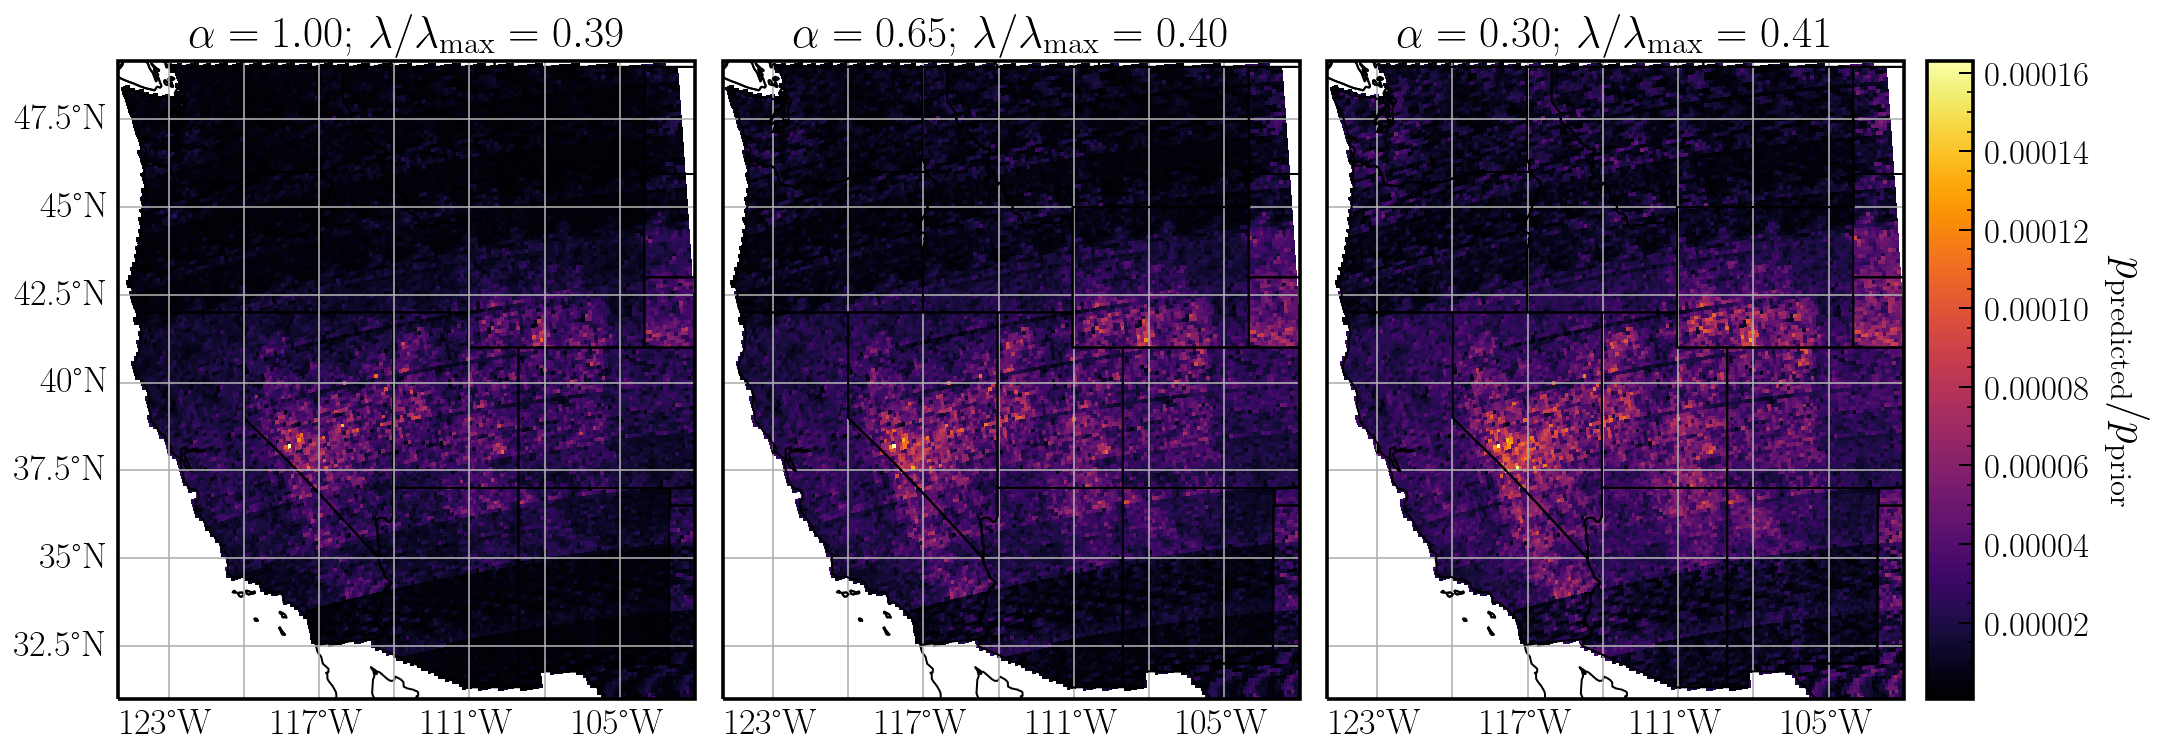

In [22]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 6)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

min_path= 0.01
quad_features= 0
tindx= 3
tval_arr, lambda_arr= init_masked_pred_prob_df_func(alpha= 1, min_path= min_path, quad_features= quad_features, sav_flag= False)
CS= ax.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], init_pred_prob_xarr(alpha= 1, min_path= min_path, quad_features= quad_features, \
                                                                tval_arr= tval_arr, tindx= tindx).mean(axis= 0, skipna= False)/prior_xarr.mean(axis= 0), cmap=plt.cm.inferno) #prior_xarr.mean(axis= 0, skipna= False)
ax.set_title(r'$\alpha= %.2f$'%(1.0) + r'; $ \lambda/\lambda_{\rm max} =%.2f$'%(lambda_arr[tval_arr[tindx]]/np.max(lambda_arr)), fontsize= 22);

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:4], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

tval_arr0, lambda_arr0= init_masked_pred_prob_df_func(alpha= 0.65, min_path= min_path, quad_features= quad_features, sav_flag= False)
CS0= ax0.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], init_pred_prob_xarr(alpha= 0.65, min_path= min_path, quad_features= quad_features, \
                                                                tval_arr= tval_arr0, tindx= tindx).mean(axis= 0, skipna= False)/prior_xarr.mean(axis= 0), cmap=plt.cm.inferno) #prior_xarr.mean(axis= 0, skipna= False)

ax0.set_title(r'$\alpha= %.2f$'%(0.65) + r'; $ \lambda/\lambda_{\rm max} =%.2f$'%(lambda_arr0[tval_arr0[tindx]]/np.max(lambda_arr0)), fontsize= 22);

fig.subplots_adjust(wspace= 0.1)

ax1= fig.add_subplot(gs[0:2, 4:6], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1) 

tval_arr1, lambda_arr1= init_masked_pred_prob_df_func(alpha= 0.3, min_path= min_path, quad_features= quad_features, sav_flag= False)
CS1= ax1.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], init_pred_prob_xarr(alpha= 0.3, min_path= min_path, quad_features= quad_features, \
                                                                tval_arr= tval_arr1, tindx= tindx).mean(axis= 0, skipna= False)/prior_xarr.mean(axis= 0), cmap=plt.cm.inferno) #prior_xarr.mean(axis= 0, skipna= False)

#CS= ax0.pcolormesh(lat_long_fire_grid[0], lat_long_fire_grid[1], pred_freq_xarr.mean(axis= 0)/prior_xarr.mean(axis= 0), cmap=plt.cm.inferno) # normalized fire probability summed over all months
cax= fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
cbar= fig.colorbar(CS1, cax= cax, shrink= 0.7)
cbar.set_label(r'$p_{\rm predicted}/p_{\rm prior}$', labelpad= 30, rotation= 270, fontsize= 22)
ax1.set_title(r'$\alpha= %.2f$'%(0.3) + r'; $ \lambda/\lambda_{\rm max} =%.2f$'%(lambda_arr1[tval_arr1[tindx]]/np.max(lambda_arr1)), fontsize= 22);
#plt.savefig('../paper_plots/maxent_output_alpha_plt.png', bbox_inches='tight', dpi= 200);